<a href="https://colab.research.google.com/github/rngwlf/comp551-notebooks/blob/master/matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

### Setting

In [ ]:
import numpy as np
import pandas as pd
import collections
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Assume we have dataframes: 

ratings with column user_id, movie_id, rating

users with column user_id,... (here the users are those who have ratings)

movies with movie_id, genre, ... (here the movies are those who have ratings)

### SparseTensor representation of Rating Matrix (for efficient representation)
Input: A DataFrame represnting the user ratings for different movies. It should have three columns: userid, moveid, rating.

Output: A SparseTensor

A SparseTensor uses three tensors to represent the matrix: tf.SparseTensor(indices, values, dense_shape) represents a tensor, where a value  Aij=a  is encoded by setting indices[k] = [i, j] and values[k] = a

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [ ]:
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Loss function: MSE

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

### CFModel class
This is a class to train a matrix factorization using gradient descent.

In [ ]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  print(A_test)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

### Give recommendataions


Compute the scores using dot product or cosin.

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

Rank the score and give the 20 highest ranking movies.

In [ ]:
def user_recommendations(model, uid, measure=DOT, exclude_rated=False, k=20):
  
  scores = compute_scores(
      model.embeddings["user_id"][uid], model.embeddings["movie_id"], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'movie_id': movies['movie_id'],
      'titles': movies['title'],
      #'genres': movies['all_genres'],
  })
  if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == f"uid"]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
  display.display(df.sort_values([score_key], ascending=False).head(k))
  return(df.sort_values([score_key], ascending=False)['titles'].head(k).tolist())

# Test
For now, use Movie lens 100k to test the model.

### Load data

In [ ]:
from urllib.request import urlretrieve
import zipfile
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

print(users)
print(ratings)
print("\n")
print(ratings["user_id"].value_counts())
print("All users rated some movies")
print(movies)

    user_id  age sex     occupation zip_code
0         0   24   M     technician    85711
1         1   53   F          other    94043
2         2   23   M         writer    32067
3         3   24   M     technician    43537
4         4   33   F          other    15213
..      ...  ...  ..            ...      ...
938     938   26   F        student    33319
939     939   32   M  administrator    02215
940     940   20   M        student    97229
941     941   48   F      librarian    78209
942     942   22   M        student    77841

[943 rows x 5 columns]
      user_id movie_id  rating  unix_timestamp
0         195      241     3.0       881250949
1         185      301     3.0       891717742
2          21      376     1.0       878887116
3         243       50     2.0       880606923
4         165      345     1.0       886397596
...       ...      ...     ...             ...
99995     879      475     3.0       880175444
99996     715      203     5.0       879795543
99997     275

### Train model and predict

SparseTensor(indices=Tensor("SparseTensor_7/indices:0", shape=(10000, 2), dtype=int64), values=Tensor("SparseTensor_7/values:0", shape=(10000,), dtype=float64), dense_shape=Tensor("SparseTensor_7/dense_shape:0", shape=(2,), dtype=int64))
 iteration 500: train_error=0.503862, test_error=1.301145

[{'train_error': 0.50386184, 'test_error': 1.3011453}]

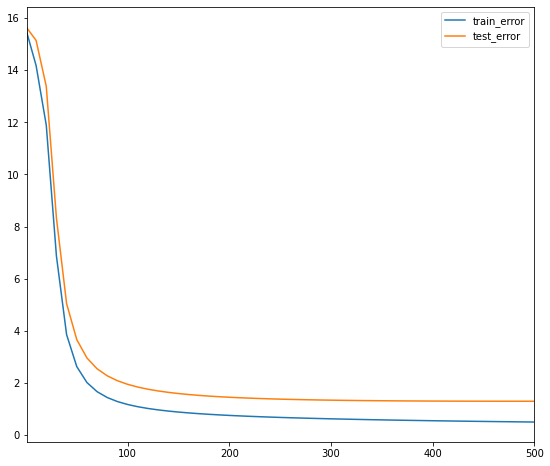

In [ ]:
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=500, learning_rate=10.)

In [ ]:
print(user_recommendations(model, uid=3, measure=COSINE, exclude_rated=True, k=20))

,cosine score,movie_id,titles
463,0.738311,463,Vanya on 42nd Street (1994)
432,0.725128,432,Heathers (1989)
269,0.717548,269,Gattaca (1997)
729,0.684877,729,"Queen Margot (Reine Margot, La) (1994)"
167,0.682280,167,Monty Python and the Holy Grail (1974)
543,0.671192,543,Things to Do in Denver when You're Dead (1995)
1038,0.667071,1038,Hamlet (1996)
937,0.657259,937,"Smile Like Yours, A (1997)"
247,0.657027,247,Grosse Pointe Blank (1997)
153,0.650709,153,Monty Python's Life of Brian (1979)


['Vanya on 42nd Street (1994)', 'Heathers (1989)', 'Gattaca (1997)', 'Queen Margot (Reine Margot, La) (1994)', 'Monty Python and the Holy Grail (1974)', "Things to Do in Denver when You're Dead (1995)", 'Hamlet (1996)', 'Smile Like Yours, A (1997)', 'Grosse Pointe Blank (1997)', "Monty Python's Life of Brian (1979)", 'North by Northwest (1959)', 'Selena (1997)', 'Star Wars (1977)', 'Full Monty, The (1997)', 'Color of Night (1994)', 'Funny Face (1957)', 'Kiss the Girls (1997)', 'Good, The Bad and The Ugly, The (1966)', 'Heat (1995)', 'Empire Strikes Back, The (1980)']
